### Approval Classification

I apply a machine learning approach to classify presidential approval using sentiment scores, party affiliation, length of the speech and number of words in a speech. Using sentiment scores alone leads to some decent models with accuracy better than 50%, but the predictive value of sentiment goes away when other features are added. 

In [1]:
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['legend.fontsize'] = 20

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve, confusion_matrix
from sklearn.grid_search import ParameterGrid

% run scripts/evaluate.py

/Users/ratulesrar/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ratulesrar/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# import data
df = pd.read_pickle('data/clean_speech_approvals.pkl')
df.set_index('president', inplace=True)

feat = ['approval', 'compound', 'positive', 'negative', 'neutral', 'party', 
        'approve_mean', 'approve_median', 'approve_min', 'approve_max', 'approve_std',
        'disapprove_mean', 'disapprove_median', 'disapprove_min', 'disapprove_max',
        'disapprove_std', 'num_words', 'num_sentences']

sentiment = ['approval', 'compound', 'num_words', 'num_sentences']

In [3]:
def binary_approval(approve):
    if approve > 50:
        return 1
    else:
        return 0

def to_binary(df, col, val='t'):
    '''
    Converts column to binary based on value
    '''
    df[col] = df[col].apply(lambda x: 1 if x == val else 0)

In [4]:
to_binary(df, 'party', 'D')

df['approval'] = df['approve_mean'].apply(binary_approval)

In [5]:
# create X, y vectors
X = df.filter(sentiment)
X = X.drop('approval', axis=1)
y = df['approval'].to_frame()

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=37)

# validation split
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=3)

# set model parameters
params = {'penalty': ['l1','l2'], 'C': [0.00001,0.0001,0.001,0.01,0.1,1,10]}

In [6]:
def get_feature_importance(clf, model_name):
    clfs = {'RF':'feature_importances',
            'LR': 'coef',
            'SVM': 'coef',
            'DT': 'feature_importances',
            'KNN': None,
            'AB': 'feature_importances',
            'GB': None,
            'linear.SVC': 'coef',
            'ET': 'feature_importances'
            }

    if clfs[model_name] == 'feature_importances':
        return  list(clf.feature_importances_)
    elif clfs[model_name] == 'coef':
        return  list(clf.coef_.tolist())
    else:
        return None

In [7]:
def clf_loop(X_train, X_test, y_train, y_test, params):
    '''
    Function to loop through hyperparameters in a model
    '''
    results_df = pd.DataFrame(columns=('clf','parameters','auc-roc','accuracy'))
    for p in ParameterGrid(params):
        try:
            clf = LogisticRegression()
            clf.set_params(**p)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_pred_probs = list(clf.predict_proba(X_test)[:,1])
            results_df.loc[len(results_df)] = [clf,p,roc_auc_score(y_test,y_pred_probs),
                                               accuracy_score(y_test,y_pred)]
        except IndexError:
            print('IndexError')
            continue
    return results_df

In [8]:
# run methods loop
df_validation = clf_loop(X_train, X_test, y_train, y_test, params)

# obtain params for model with max auc-roc
best_model_params = dict(df_validation.sort_values('auc-roc', ascending=False)[:1]['parameters'])
key = list(best_model_params.keys())[0]

# evaluate using test data
# lr = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
#           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
#           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
#           verbose=0, warm_start=False)
lr = LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
# lr.set_params(**best_model_params[key])
lr.fit(X_validation, y_validation)

# get predicted scores for test set
y_preds = lr.predict_proba(X_test)[:, 1]
y_preds

array([0.65943291, 0.67488872, 0.69951719, 0.58052569, 0.66539869,
       0.66276306, 0.61771343, 0.68853553, 0.62701182, 0.5910649 ,
       0.59759631, 0.63902303, 0.66014083])

In [9]:
# print feature coefficients
get_feature_importance(lr, 'LR')

[[-3.5138671091451976e-05, 0.00021505530105230827, -0.002863059985927265]]

In [10]:
X_validation.columns

Index(['compound', 'num_words', 'num_sentences'], dtype='object')

In [11]:
df_validation

,clf,parameters,auc-roc,accuracy
0,"LogisticRegression(C=1e-05, class_weight=None,...","{'penalty': 'l1', 'C': 1e-05}",0.500000,0.461538
1,"LogisticRegression(C=1e-05, class_weight=None,...","{'penalty': 'l2', 'C': 1e-05}",0.500000,0.538462
2,"LogisticRegression(C=0.0001, class_weight=None...","{'penalty': 'l1', 'C': 0.0001}",0.333333,0.538462
3,"LogisticRegression(C=0.0001, class_weight=None...","{'penalty': 'l2', 'C': 0.0001}",0.642857,0.615385
4,"LogisticRegression(C=0.001, class_weight=None,...","{'penalty': 'l1', 'C': 0.001}",0.333333,0.538462
5,"LogisticRegression(C=0.001, class_weight=None,...","{'penalty': 'l2', 'C': 0.001}",0.642857,0.615385
6,"LogisticRegression(C=0.01, class_weight=None, ...","{'penalty': 'l1', 'C': 0.01}",0.452381,0.538462
7,"LogisticRegression(C=0.01, class_weight=None, ...","{'penalty': 'l2', 'C': 0.01}",0.690476,0.615385
8,"LogisticRegression(C=0.1, class_weight=None, d...","{'penalty': 'l1', 'C': 0.1}",0.642857,0.615385
9,"LogisticRegression(C=0.1, class_weight=None, d...","{'penalty': 'l2', 'C': 0.1}",0.690476,0.538462


The model with the best area under the curve optimizes pretty well to trade off between the false positive rate and the true positive rate. That being said, the top model based on AUC only has an accuracy of 54%. This improves when including party affiliation but strictly based on sentiment, this model does not perform very well. 

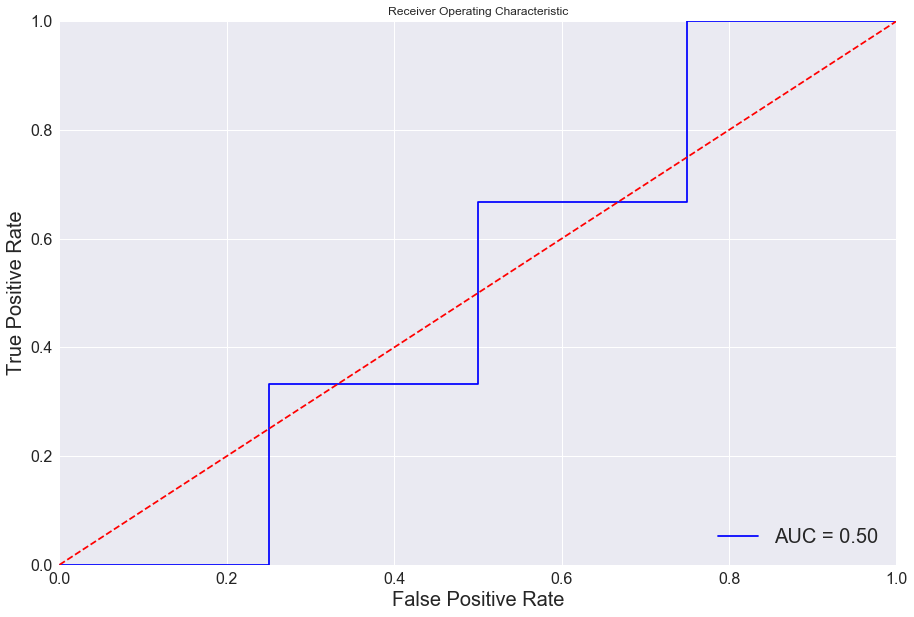

In [12]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_validation, y_preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('data/auc.png')

Confusion matrix, without normalization
[[1 3]
 [2 7]]


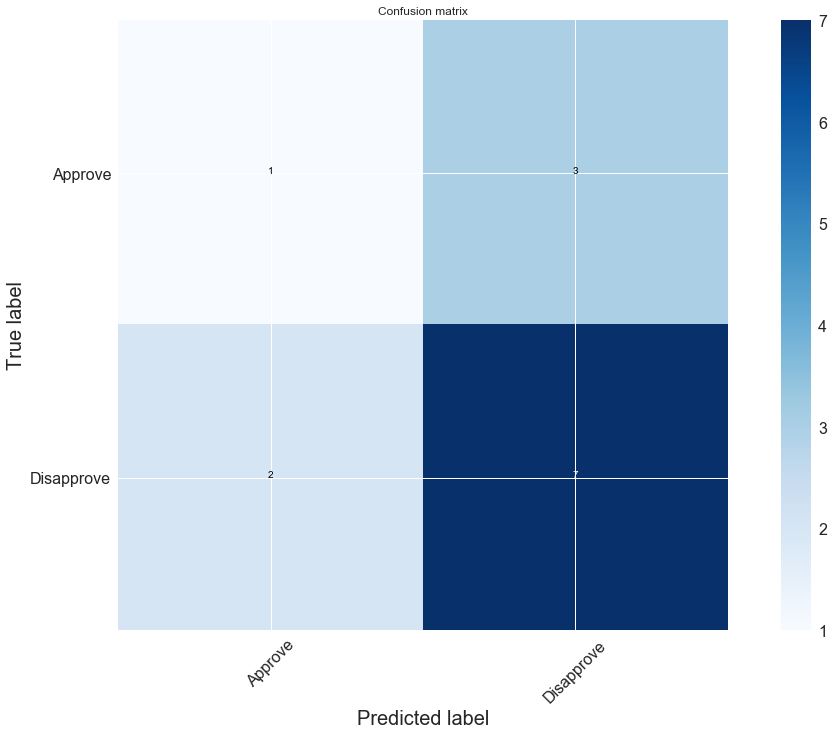

In [13]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_validation, [1 if pred > 0.6 else 0 for pred in y_preds])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
pl.figure()
plot_confusion_matrix(cnf_matrix, classes=['Approve', 'Disapprove'],
                      title='Confusion matrix')
plt.savefig('data/matrix.png')

In [14]:
get_precision(cnf_matrix)

0.3333333333333333

In [15]:
get_recall(cnf_matrix)

0.25

In [16]:
get_accuracy(cnf_matrix)

0.6153846153846154